In this notebook, we define the dynamics of the Leaky Integrator in `jax` and use max over time loss and gradient decent to train two neurons.

In [7]:
import jax
import jax.numpy as np
from functools import partial
from jaxsnn.event.leaky_integrate_and_fire import LIFParameters
from jaxsnn.base.types import Spike
import matplotlib.pyplot as plt

In [ ]:
p = LIFParameters()

t_late = 2 * p.tau_syn
t_max = 4 * p.tau_syn

Now, define the dynamics of a leaky integrator:

In [8]:
def heaviside(x):
    return 0.5 + 0.5 * np.sign(x)


def kernel(t, t0):
    # neuron dynamics
    A = np.array([[-p.tau_mem_inv, p.tau_mem_inv], [0, -p.tau_syn_inv]])
    return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))  # type: ignore


def f(t0, x0, t):
    return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, t))(t0), x0)


def li_cell(weights, spikes, ts):
    xk = np.stack((np.zeros(4), weights[spikes.idx]), axis=1)
    ys = jax.vmap(partial(f, spikes.time, xk))(ts)
    return ys

Define four input spikes and plot the voltage and current of the leaky integrate neuron

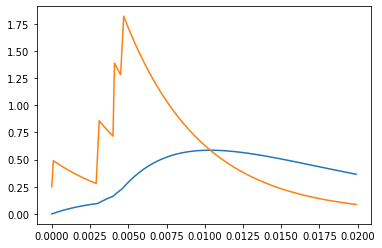

In [11]:
spikes = Spike(
    time=np.array([0.0, 0.15, 0.2, 0.23]) * t_max,
    idx=np.array([0, 1, 2, 1])
)

weights = np.array([0.5, 0.6, 0.7])

ts = np.arange(0, t_max, 1e-4)  # time grid to evaluate on
ys = li_cell(weights, spikes, ts)
plt.plot(ts, ys)
plt.show()

Now, we use vmap to define a layer of two neurons. The size is determined by the shape of weights. As both neurons have different input weights, they react differently to the input spikes.

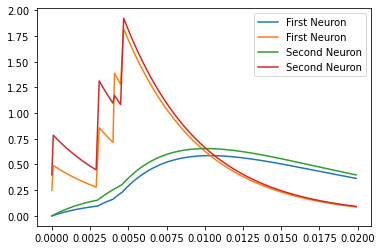

In [13]:
leaky_integrator = jax.vmap(li_cell, in_axes=(1, None, None), out_axes=1)

weights = np.array(
    [
        [0.5, 0.8],
        [0.6, 0.9],
        [0.7, 0.1],
    ]
)
output = leaky_integrator(weights, spikes, ts)
first_neuron, second_neuron = output[:, 0], output[:, 1]
plt.plot(ts, first_neuron, label="First Neuron")
plt.plot(ts, second_neuron, label="Second Neuron")
plt.legend()
plt.show()

Create a max over time function to evaluate and use it to define a loss function which returns a scalar value

In [16]:
def max_over_time(output):
    return np.max(output[::, 0], axis=0)


def nll_loss(max_voltage, targets):
    preds = jax.nn.log_softmax(max_voltage)
    loss = -np.sum(targets * preds)
    return loss


def loss_fn(weights, batch):
    spikes, targets = batch
    output = leaky_integrator(weights, spikes, ts)
    max_voltage = max_over_time(output)
    return nll_loss(max_voltage, targets)

We now have a loss value dependant on the input spikes and weights

In [20]:
spikes = Spike(
    time=np.array([0, 0.2, 0.25, 0.4]) * t_max,
    idx=np.array([0, 1, 2, 1])
)
targets = np.array([1.0, 0.0])
batch = (spikes, targets)
value = loss_fn(weights, batch)
value

DeviceArray(1.1612835, dtype=float32)

To train this, we simply take the gradient and update the weights.

In [30]:
# can we train this?
weights = np.array(
    [
        [0.5, 0.8],
        [0.6, 0.9],
        [0.7, 0.1],
    ]
)

loss = []
for i in range(100):
    value, grads = jax.value_and_grad(loss_fn)(weights, batch)
    loss.append(value)
    weights = jax.tree_map(lambda w, dw: w - 0.1 * dw, weights, grads)

Visualize the training results:

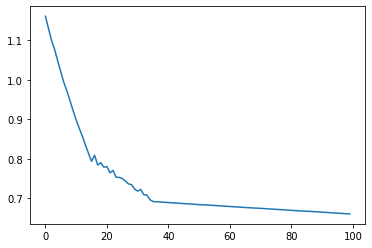

In [33]:
plt.plot(np.arange(len(loss)), loss)
plt.show()